In [ ]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import numpy as np
import matplotlib.pyplot as plt

import archimedes as arc
from archimedes import struct, field

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

# Part 2: Duffing Oscillator

In [Part 1](
../../generated/notebooks/sysid/sysid01) of this series we saw a simple workflow for estimating unknown model parameters from data in Archimedes using the example of a linear second-order system.

Next we'll use data from a more complex nonlinear oscillator see how to:

* Create scalable model reperesentations using [PyTree](../../trees.md) data structures
* Handle unknown initial conditions
* Impose physically-motivated bounds on the model parameters
* Identify nonlinear dynamical system models (spoiler: it's the same as linear models)

As always, let's start with the data:

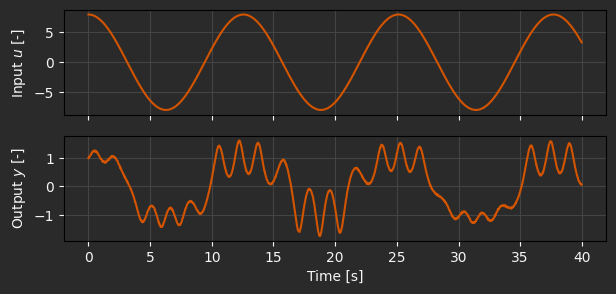

In [2]:
raw_data = np.loadtxt("data/duffing.csv", skiprows=1, delimiter="\t")

data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)
dt = data.ts[1] - data.ts[0]

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(data.ts, data.us[0], label="Input ($u$)")
ax[0].set_ylabel("Input $u$ [-]")
ax[0].grid()
ax[1].plot(data.ts, data.ys[0], label="Output ($y$)")
ax[1].set_ylabel("Output $y$ [-]")
ax[1].grid()
ax[-1].set_xlabel("Time [s]")
plt.show()

In this tutorial series we will continue to gloss over the _really_ hard part of nonlinear system identification, which is determining an appropriate model structure.

Here we'll assume that through some combination of data analysis and physical reasoning we've landed on the weakly nonlinear [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation) as a candidate model.

$$
\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = u
$$

We'll treat the forcing as known time-series data, but usually it's a sinusoidal function $u(t) = \gamma \cos(\omega)$.

This is not as farfetched as it might sound; a common way to end up with a Duffing model is as follows:

1. Examing frequency response data and determine that the system acts roughly like a second-order oscillator $\ddot{x} + \delta \dot{x} + k x = u $.
2. Attempt to fit a linear oscillator model to the data, with poor results.
3. After some more analysis and physical modeling, realize that the stiffness is actually a nonlinear function $k(x)$.
4. Based on the symmetry of the problem, determine that the Taylor expansion of $k(x)$ is $k(0) + k''(0)/2 x^2$.
5. Since the exact form of $k(x)$ is unknown, parameterize it with the value and second derivative at zero: $\alpha = k(0)$, $\beta = k''(0)/2$.

This combination of data analysis, physical reasoning, intuition, and asymptotic expansion is common in nonlinear system identification.
While not as robust as first-principles modeling and perhaps not as satisfying to peer reviewers as black-box models, when done properly it can be an an intuitive, interpretable way to incorporate nonlinear effects.


### Implementation

Our nonlinear dynamics is a continuous-time function of three parameters, which we will need to implement in the discrete-time state-space form

\begin{align}
x_{k+1} &= f(t_k, x_k, u_k; p) \\
y_k &= h(t_k, x_k, u_k; p)
\end{align}

As in [Part 1](
../../generated/notebooks/sysid/sysid01), we will first implement the continuous-time dynamics model and then use the [`discretize`](#archimedes.discretize) function to transform to a discrete-time difference equation.
Previously, we implemented the model as a standard Python function with a flat parameter vector.
For the Duffing model, this might look like

```python
# ODE model
def duffing_ode(t, x, u, p):
    x1, x2 = x
    alpha, beta, delta = p
    x2_t = -alpha * x1 - beta * x1 ** 3 - delta * x2 + u[0]

    return np.hstack([x2, x2_t])

# Observation model
def obs(t, x, u, p):
    return x[0]

# Discretize with RK4 time-stepping
dyn = arc.discretize(duffing_ode, dt, method="rk4")
```

As for the linear oscillator, this is easy enough for this simple case.
However, this approach doesn't scale well to complex systems.

Imagine for example a model of a hydraulic system coupled to some mechanical load.
The system is naturally represented hierarchically, with subsystems and components.
Each of these components may have its own parameters, potentially including coefficients for pressure loss correlations and parametric pump efficiency curves.
Manually unpacking and repacking a flat parameter vector quickly becomes tedious and error-prone.

Archimedes solves this problem with [PyTree](../../trees.md) data structures, specifically the [`@pytree_node`](#archimedes.struct) class decorator.
If you are not familiar with this concept, it may be worth taking a moment to read the documentation pages on [Working with PyTrees](../../trees.md) and [Hierarchical Design Patterns](../../generated/notebooks/modular-design.md).

In short, we will replace this "flat function" implementation with a PyTree node class that has parameters as fields.
In this simple case we will only have one node, but instances of these node classes can be nested arbitrarily, allowing you to create reusable patterns and components.
The system identification tools in Archimedes can work directly with PyTrees, meaning that you can pass the entire model directly to the optimizer.
Later we'll also show a simple pattern for optimizing only a subset of the model parameters.

These PyTree nodes are essentially supercharged dataclasses, so there is a lot of flexibility in how you define and work with them, but here's how we might implement the Duffing oscillator, following a common pattern for implementing dynamics models:

In [3]:
@struct
class DuffingOscillator:
    alpha: float
    beta: float
    delta: float

    def dynamics(self, t, x, u):
        x1, x2 = x
        return np.hstack(
            [
                x2,
                -self.alpha * x1 - self.beta * x1**3 - self.delta * x2 + u[0],
            ]
        )

    def observation(self, t, x, u):
        return x[0]

This is _almost_ what we need, but the system ID functionality expects a discrete-time model with the signature `dyn(t, x, u, p)`.
So we do still need a small bit of boilerplate to wrap the PyTree model:

In [4]:
def ode(t, x, u, model):
    return model.dynamics(t, x, u)


def obs(t, x, u, model):
    return model.observation(t, x, u)


dyn = arc.discretize(ode, dt, method="rk4")

Notice that the _model itself_ takes the place of the parameter vector in the previous implementation.  Again, there is a lot of flexibility here; we'll show a more precise way to optimize only a subset of the parameters later that will give you some idea of different ways to set up the identification problem.

## Optimizing the parameters

Now we can make an initial guess by creating an instance of the model with rough estimates of the parameters.  As always with nonlinear system ID, the better you can initialize these parameters the more likely the optimizer is to find a good solution.

In [35]:
model_guess = DuffingOscillator(alpha=0.9, beta=4.9, delta=0.03)
print(model_guess)

DuffingOscillator(alpha=0.9, beta=4.9, delta=0.03)




We'll also build on the previous example by tackling the case where we don't know what the initial condition of the system was and letting the optimizer estimate it along with the parameters

In [37]:
x0_guess = np.array([data.ys[0, 0], 0.0])  # Initial state guess

We are almost ready to run the system identification algorithm.
Before we do, we need to consider one new wrinkle compared to the previous linear model: validation.
A linear system is fully characterized by its step response, so _if_ we are confident the system is linear then it is sufficient to reproduce the step response.
For nonlinear systems the story is much more complicated and it is very challenging to fully validate the model under all circumstances.

Here we'll do a simple cross-validation check for the sake of simplicity.
We can split the full time series in half and use the first half to fit the model and the second half to evaluate it against "different" data - in quotation marks because the system is really operating in a very similar regime across this timeseries.
In practice you might want to consider collecting various kinds of response data: the natural system, steady-state response, frequency sweeps, amplitude sweeps, etc. and using these to validate the model across both nominal and off-nominal operating conditions.

In [38]:
train_data = data[: len(data) // 2]

From here we can almost copy-paste the code from the linear oscillator example.  One final modification is that we will not pass the initial state through the `x0` keyword argument since it is part of the parameters to be optimized.
Instead, we will pass our guess for the initial state as part of the decision variables, which is now a tuple `(x0_guess, model_guess)`.


In [ ]:
# Estimate the parameters of the system
nu = 1  # Number of inputs
ny = 1  # Number of outputs
nx = 2  # Number of states

# A simple way to estimate the noise variance is to use the
# variance of the differences of the output data - if the output
# was constant, this would give a good estimate of Gaussian noise.
noise_var = 0.5 * np.var(np.diff(data.ys[0]))

# Estimates of measurement and process noise covariance
R = noise_var * np.eye(ny)  # Measurement noise
Q = 1e-2 * noise_var * np.eye(nx)  # Process noise

# Set up PEM problem
ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R)
result = arc.sysid.pem(
    ekf,
    train_data,  # Train on the first half of the data
    (x0_guess, model_guess),
)

x0_opt, model_opt = result.x

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         5.2172e-02                                   1.02e-02  
    1           3         5.2157e-02       1.58e-05       6.21e-03     1.30e-05  
    2           4         5.2157e-02       2.72e-11       1.71e-05     2.58e-08  
Both actual and predicted relative reductions in the sum of squares are at most ftol


Let's run the estimated model forward and compare to the _full_ dataset, including the "test" data that the model hasn't seen yet.

In [40]:
# Validate forward simulation accuracy
def ode_rhs(t, x, model):
    u = np.interp(t, data.ts, data.us[0])
    u = np.atleast_1d(u)
    return model.dynamics(t, x, u)


xs_pred = arc.odeint(
    ode_rhs,
    t_span=(data.ts[0], data.ts[-1]),
    x0=x0_opt,
    args=(model_opt,),
    t_eval=data.ts,
)
ys_pred = xs_pred[:1, :]

In [41]:
train_data.ts[-1]

np.float64(19.98)

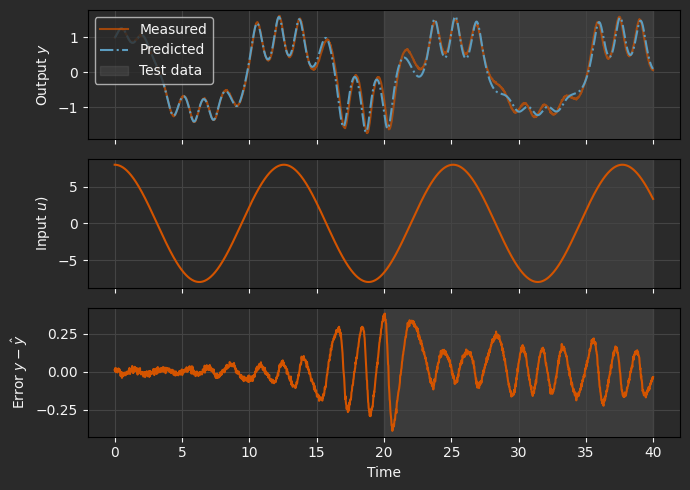

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# State trajectory
ax[0].plot(data.ts, data.ys[0], label="Measured", alpha=0.7)
ax[0].plot(data.ts, ys_pred[0], label="Predicted", linestyle="-.")

# Shade in the test data
ax[0].axvspan(
    train_data.ts[-1], data.ts[-1], color="gray", alpha=0.2, label="Test data"
)

ax[0].legend(loc="upper left")
ax[0].grid()
ax[0].set_ylabel("Output $y$")

# Forcing input
ax[1].plot(data.ts, data.us[0])
ax[1].axvspan(
    train_data.ts[-1], data.ts[-1], color="gray", alpha=0.2, label="Test data"
)

ax[1].set_ylabel("Input $u$)")
ax[1].grid()

# Error
ax[2].plot(data.ts, data.ys[0] - ys_pred[0])
ax[2].axvspan(
    train_data.ts[-1], data.ts[-1], color="gray", alpha=0.2, label="Test data"
)

ax[2].set_ylabel(r"Error $y - \hat{y}$")
ax[2].grid()

ax[-1].set_xlabel("Time")

plt.tight_layout()
plt.show()

Not bad!  We do see some drift over time, but over this many oscillaton periods that's generally to be expected.

A more accurate, but somewhat more involved, way to validate against the test data would be to simulate _only_ the test data, since there were already significant error levels by the time we reached the test region.
Initial conditions for such an evaluation could be roughly estimated directly (e.g. with finite differencing) or optimized by re-running the system ID problem using the test data but _fixing_ the parameters of the system (that is, optimizing only the intial condition estimate).

Since this is synthetic data, we can also cheat and just compare to the real values:

In [34]:
# Load and compare to true parameters

true_params = np.load("data/duffing_truth.npz")


print(f"Estimated initial state:       {x0_opt}")
print(f"True initial state:            {true_params['x0']}")

print()
print(f"Estimated linear stiffness:    {model_opt.alpha:.4f}")
print(f"True linear stiffness:         {true_params['alpha']:.4f}")

print()
print(f"Estimated nonlinear stiffness: {model_opt.beta:.4f}")
print(f"True nonlinear stiffness:      {true_params['beta']:.4f}")

print()
print(f"Estimated damping:             {model_opt.delta:.4f}")
print(f"True damping:                  {true_params['delta']:.4f}")

Estimated initial state:       [0.98340595 0.50820027]
True initial state:            [1.  0.5]

Estimated linear stiffness:    0.9439
True linear stiffness:         1.0000

Estimated nonlinear stiffness: 5.0268
True nonlinear stiffness:      5.0000

Estimated damping:             0.0298
True damping:                  0.0200


## Fine-grained control: parameter surgery

The previous example showed how we can use PyTrees to optimize all the parameters in a hierarchical model.
But it's not always the case that we want to optimize _all_ the parameters.
Fortunately there are some simple patterns to estimate only certain parameters.

For example, let's say that we've done some small-amplitude analysis and have a confident estimate of the linear stiffness $\alpha$ , but we don't know what the nonlinear stiffness $\beta$ and the damping $\delta$ are.
An easy way to handle this case is to write a "glue function" that accepts a dictionary of parameters instead of the model itself, and then replaces the parameters.
Since dictionaries are also valid PyTrees, we can optimize the dictionary of parameters instead of the entire model.

Here's what this looks like:

In [ ]:
init_model = DuffingOscillator(
    alpha=true_params["alpha"],  # We'll keep this fixed
    beta=0.0,  # Unknown parameter: initial guess
    delta=0.0,  # Unknown parameter: initial guess
)


# Rewrite the original ODE model to accept a dict of parameters
# instead of the full model
def ode(t, x, u, params):
    model = init_model.replace(**params)  # New model with updated parameters
    return model.dynamics(t, x, u)


# Same thing for the observation model
def obs(t, x, u, params):
    model = init_model.replace(**params)
    return model.observation(t, x, u)


dyn = arc.discretize(ode, dt, method="rk4")

params_guess = {
    "beta": model_guess.beta,
    "delta": model_guess.delta,
}

# Set up PEM problem
ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R)
result = arc.sysid.pem(
    ekf,
    train_data,  # Train on the first half of the data
    (x0_guess, params_guess),
)

x0_opt, params_opt = result.x

print(f"Optimized initial state: {x0_opt}")
print(f"Optimized parameters:    {params_opt}")  # Returns a dictionary, not the model

# If we want the full model, we just replace the optimized parameters
model_opt = init_model.replace(**params_opt)

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         5.3008e-02                                   3.51e-03  
    1           3         5.3006e-02       1.91e-06       1.95e-03     2.55e-06  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Optimized initial state: [0.98338247 0.50954601]
Optimized parameters:    {'beta': array(4.98540129), 'delta': array(0.03204956)}


With this pattern you can choose which parameters to fix and which to optimize, which can be useful if you can accurately estimate certain parameters.

One other way to do this that's worth mentioning here is _static fields_.
If you have a parameter that you're _sure_ you will not need to optimize, perform sensitivity analysis on, etc. then you can declare this parameter as "static" in the PyTree.
If you do this then the static parameters will not be optimized and will not appear in any "raveled" representation of the model.

For example:

In [ ]:
@struct
class GravitySpring:
    g: float = field(static=True)  # Gravity - never changes
    k: float
    m: float

    def dynamics(self, t, x):
        x1, x2 = x
        return np.hstack([x2, -self.g - self.k / self.m * x1])


spring = GravitySpring(g=9.81, k=1.0, m=2.0)

([1.0, 2.0], PyTreeDef(GravitySpring(g=9.81, k=*, m=*)))



Now when we do PyTree operations, gravity appears in the "treedef" and not the array of "leaf" data.
This means that the optimizer will not treat the gravity as a decision variable even if you pass the entire model as in the first example of this part.

In [52]:
arc.tree.flatten(spring)

([1.0, 2.0], PyTreeDef(GravitySpring(g=9.81, k=*, m=*)))

## Parameter bounds

A common scenario for nonlinear system identification, particularly "gray-box" systems with partially known physics, is that some of the variables have known ranges.
In our Duffing oscillator, for example, a simple dynamical systems analysis shows that the nonlinear damping must be positive or the system will be unstable.

We can implement bounds by creating PyTrees of the same structure as the initial guess, but populating them with upper and lower bounds.
Any unbounded variables can use `np.inf`.  The default solver (a custom Levenberg-Marquardt method) handles these box constraints automatically.

In [69]:
# Set up PEM problem

params_guess = {
    "beta": model_guess.beta,
    "delta": model_guess.delta,
}
x0_guess = np.array([data.ys[0, 0], 0.0])  # Initial state guess

lb_params = {
    "beta": 0.0,  # Lower bound for nonlinear stiffness
    "delta": -np.inf,  # No lower bound for damping
}
lb_x0 = np.array([-np.inf, -np.inf])  # No lower bound for initial state

ub_params = {
    "beta": np.inf,  # No upper bound for nonlinear stiffness
    "delta": np.inf,  # No upper bound for damping
}
ub_x0 = np.array([np.inf, np.inf])  # No upper bound for initial state

result = arc.sysid.pem(
    ekf,
    train_data,  # Train on the first half of the data
    (x0_guess, params_guess),
    bounds=(
        (lb_x0, lb_params),
        (ub_x0, ub_params),
    ),
)

x0_opt, params_opt = result.x

print(f"Optimized initial state: {x0_opt}")
print(f"Optimized parameters:    {params_opt}")  # Returns a dictionary, not the model

# If we want the full model, we just replace the optimized parameters
model_opt = init_model.replace(**params_opt)

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         5.3008e-02                                   3.51e-03  
    1           3         5.3006e-02       1.91e-06       1.95e-03     2.55e-06  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Optimized initial state: [0.98338247 0.50954601]
Optimized parameters:    {'beta': array(4.98540129), 'delta': array(0.03204956)}


## Recap

In Part 2 we explored a few new dimensions of the system identification toolkit using data from the nonlinear Duffing oscillator.  First, we saw how to move from "flat" functions to a PyTree representation of the state-space model.  For this system the payoff is minimal, but for more realistic complex systems, this allows you to create reusable components, define standardized interfaces, and construct hierarchical models of the system.  

The system identification interface works with PyTree-structured parameters by default, so we can optimize these models directly without needing to flatten/unflatten parameter vectors.  Alternatively, we looked at a couple of simple patterns for optimizing only a subset of the full parameters if you need more fine-grained control.

Finally, we saw how to add bounds to the parameters, allowing you to set reasonable limits and enforce physical restrictions on your model.

**What's next:** In [Part 3](
../../generated/notebooks/sysid/sysid03) of this series we will explore a lower-level interface for system identification that will allow us to construct customized optimization problems including multi-experiment optimization and nonlinear constraints.  Finally, [Part 4](sysid04.md) will give some basic practical recommendations for system identification, covering topics like validation, experiment design, and model parameterization.